# Fitting Gaussian Profiles

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import ugradio

### A Quick Aside: Radiometer Equation

The radiometer equation relates the noise/uncertainty on a measurement to the total power (or temperature) entering the system.

\begin{equation}
T_{\rm rms} = \frac{T_{\rm sys}}{\sqrt{2 B t}}
\end{equation}

In [2]:
SIZE = 10000
TSYS = 1
noise = TSYS * np.random.normal(size=SIZE)
#print(np.mean(noise))
#print(np.mean(noise**2))
#print(np.std(noise**2))

In [3]:
def gen_mock_profile(freqs, amp, avg, sig, noise_lev=1):
    signal = ugradio.gauss.gaussval(freqs, amp=amp, avg=avg, sig=sig)
    #signal = 0
    #for T, nu0, sig in zip(Ts, nu0s, sigmas):
    #    signal += T * np.exp(-(nu0 - freqs)**2 / (2 * sig**2))
    return signal + noise_lev * np.random.normal(size=freqs.shape)

<IPython.core.display.Javascript object>


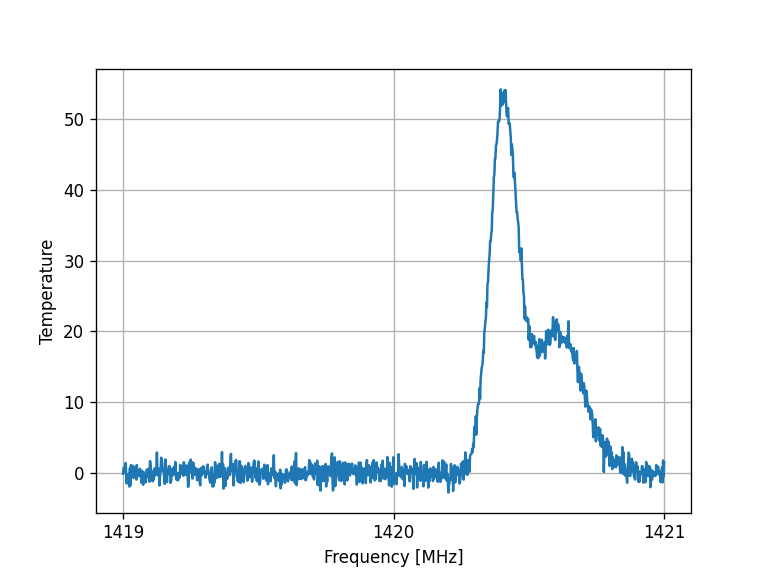

In [4]:
NCHAN = 1024
TSYS = 1
freqs = np.linspace(1419e6, 1421e6, NCHAN)
prms_true = {
    'amp': np.array([50, 20]),
    'avg': np.array([1420.405e6, 1420.6e6]),
    'sig': np.array([0.05e6, 0.1e6])
}
T21 = gen_mock_profile(freqs, noise_lev=TSYS, **prms_true)
plt.figure()
plt.plot(freqs/1e6, T21)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
_ = plt.grid()

## Method 1: Gaussfit using (under the hood) scipy.curvefit

In [5]:
ans1 = ugradio.gauss.gaussfit(freqs, T21, amp=20, avg=1420.5e6, sig=1e6)
profile1 = ugradio.gauss.gaussval(freqs, **ans1)

<IPython.core.display.Javascript object>


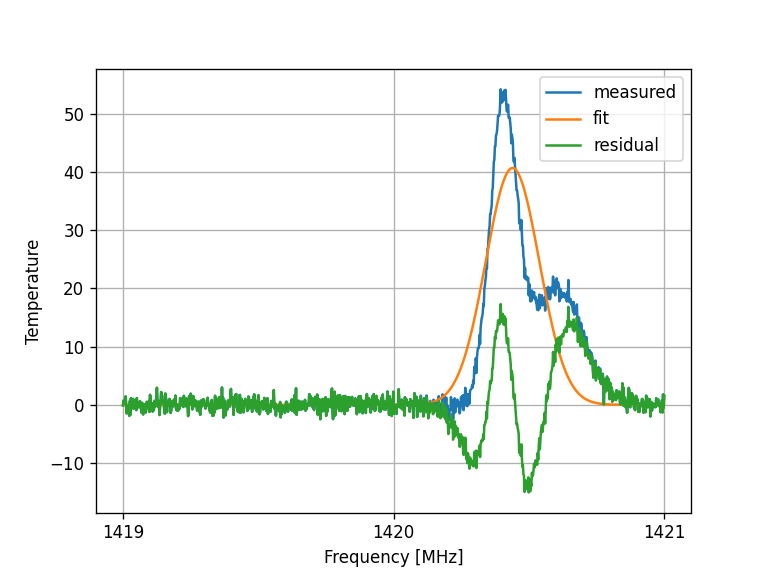

In [6]:
plt.figure()
plt.plot(freqs/1e6, T21, label='measured')
plt.plot(freqs/1e6, profile1, label='fit')
plt.plot(freqs/1e6, T21 - profile1, label='residual')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
plt.legend()
_ = plt.grid()

In [7]:
chisq = np.sum(np.abs(T21 - profile1)**2 / TSYS**2)
print(f'Chi-Square: {chisq}')

Chi-Square: 26436.84455145247


In [8]:
chisq_r = np.sum(np.abs(T21 - profile1)**2 / TSYS**2) / (freqs.size - 3)
print(f'Reduced Chi-Square: {chisq_r}')

Reduced Chi-Square: 25.893089668415737


In [9]:
ans2 = ugradio.gauss.gaussfit(freqs, T21, amp=[20,20], avg=[1420.4e6,1420.6e6], sig=[1e5,1e5])
profile2 = ugradio.gauss.gaussval(freqs, **ans2)

In [10]:
chisq = np.sum(np.abs(T21 - profile2)**2)
print(f'Chi-Square: {chisq}')
chisq_r = np.sum(np.abs(T21 - profile2)**2 / TSYS**2) / (freqs.size - 6)
print(f'Reduced Chi-Square: {chisq_r}')

Chi-Square: 974.0426394573171
Reduced Chi-Square: 0.9568198815887202


<IPython.core.display.Javascript object>


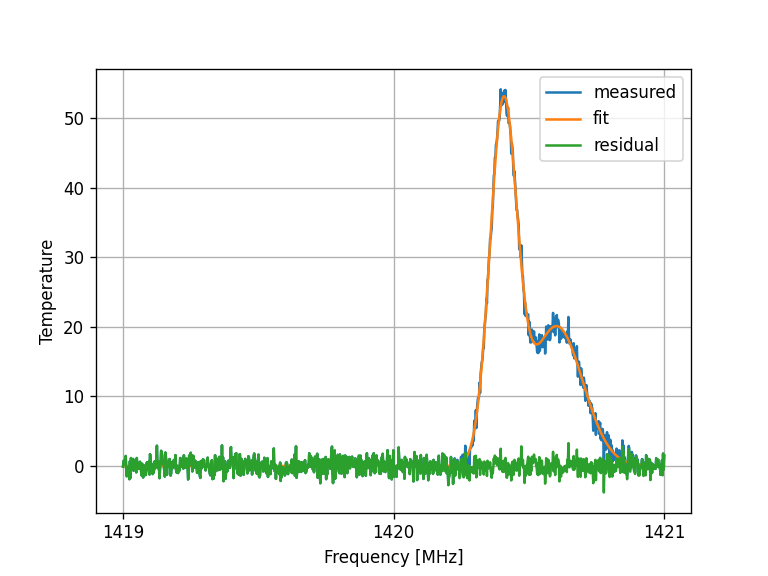

In [11]:
plt.figure()
plt.plot(freqs/1e6, T21, label='measured')
plt.plot(freqs/1e6, profile2, label='fit')
plt.plot(freqs/1e6, T21 - profile2, label='residual')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
plt.legend()
_ = plt.grid()

In [12]:
print(ans2)

{'amp': array([50.54526574, 20.09981463]), 'avg': array([1.42040553e+09, 1.42060222e+09]), 'sig': array([49898.98403869, 97022.19213916])}


In [13]:
amp0, amp1 = ans2['amp'].copy()
#amp0, amp1 = prms_true['amp'].copy()
amp0s = np.linspace(0.95*amp0, 1.05*amp0, 200)
chisq = []
for amp0_test in amp0s:
    prms = {k: v.copy() for k, v in ans2.items()}
    #prms = {k: v.copy() for k, v in prms_true.items()}
    prms['amp'] = np.array([amp0_test, amp1])
    _profile = ugradio.gauss.gaussval(freqs, **prms)
    chisq.append(np.sum(np.abs(T21 - _profile)**2/TSYS**2))

amp = 50.545265736447845 +/- 0.29209575676841837


<IPython.core.display.Javascript object>


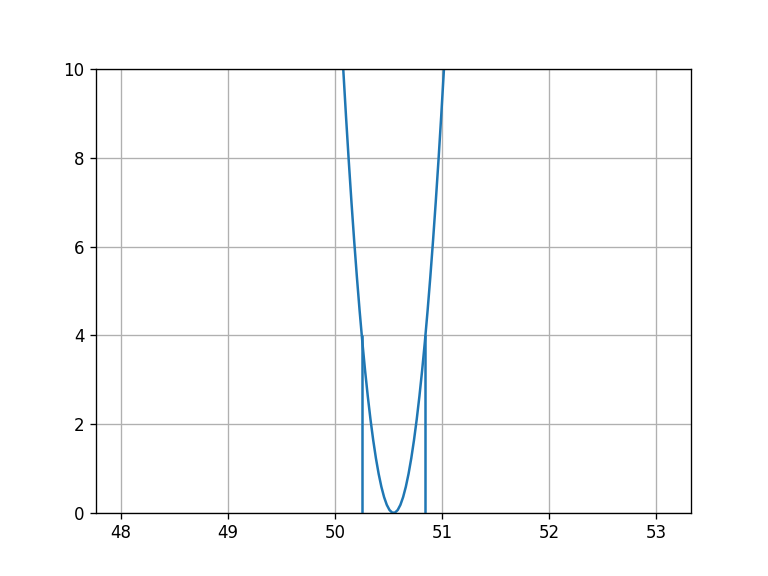

In [14]:
chisq_norm = np.array(chisq).copy()
chisq_norm -= chisq_norm.min()
inds = np.argwhere(chisq_norm < 2**2)
amp_min, amp_max = amp0s[inds[0]], amp0s[inds[-1]]
print(f'amp = {amp0} +/- {(amp_max[0] - amp_min[0])/2}')
plt.figure()
plt.plot(amp0s, chisq_norm)
plt.vlines([amp_min, amp_max], ymin=0, ymax=4)
plt.ylim(0, 10)
_ = plt.grid()

## Markov Chain Monte Carlo (Using emcee)

In [15]:
import emcee

In [16]:
def log_prior(amp1, cen1, wid1, amp2, cen2, wid2):
    try:
        assert 30 < amp1 < 70
        assert 1420e6 < cen1 < 1420.5e6
        assert 0.01e6 < wid1 < 0.3e6
        assert 1 < amp2 < 30
        assert 1420.5e6 < cen2 < 1421e6
        assert 0.01e6 < wid2 < 0.3e6
    except(AssertionError):
        return -np.inf
    return 0.0

def log_likelihood(y, yhat, sig_noise):
    L = -0.5*(np.log(2 * np.pi * sig_noise**2) + (y - yhat)**2 / sig_noise**2 )
    return np.sum(L)

def gauss(x, amp, center, width):
    return amp * np.exp(-(x - center)**2 / (2 * width**2))

def log_probability(prms, freqs, t21, tsys):
    amp1, cen1, wid1, amp2, cen2, wid2 = prms
    lp = log_prior(amp1, cen1, wid1, amp2, cen2, wid2)
    yhat = gauss(freqs, amp1, cen1, wid1) + gauss(freqs, amp2, cen2, wid2)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(t21, yhat, tsys)

sol0 = np.array([40, 1420.1e6, 0.02e6, 17, 1420.7e6, 0.02e6])
nprms = sol0.size
nwalkers = nprms * 2
#sol0 = sol0.reshape(1, -1) + 1e-3 * np.random.normal(size=(nwalkers, nprms))
sol0 = sol0 * (1 + 1e-4 * np.random.normal(size=(nwalkers, nprms)))

sampler = emcee.EnsembleSampler(nwalkers, nprms, log_probability, args=(freqs, T21, TSYS))
sampler.run_mcmc(sol0, 25000, progress=True);

  0%|                                                 | 0/25000 [00:00<?, ?it/s]/home/aparsons/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████| 25000/25000 [00:21<00:00, 1166.46it/s]


(9000, 6)


<IPython.core.display.Javascript object>


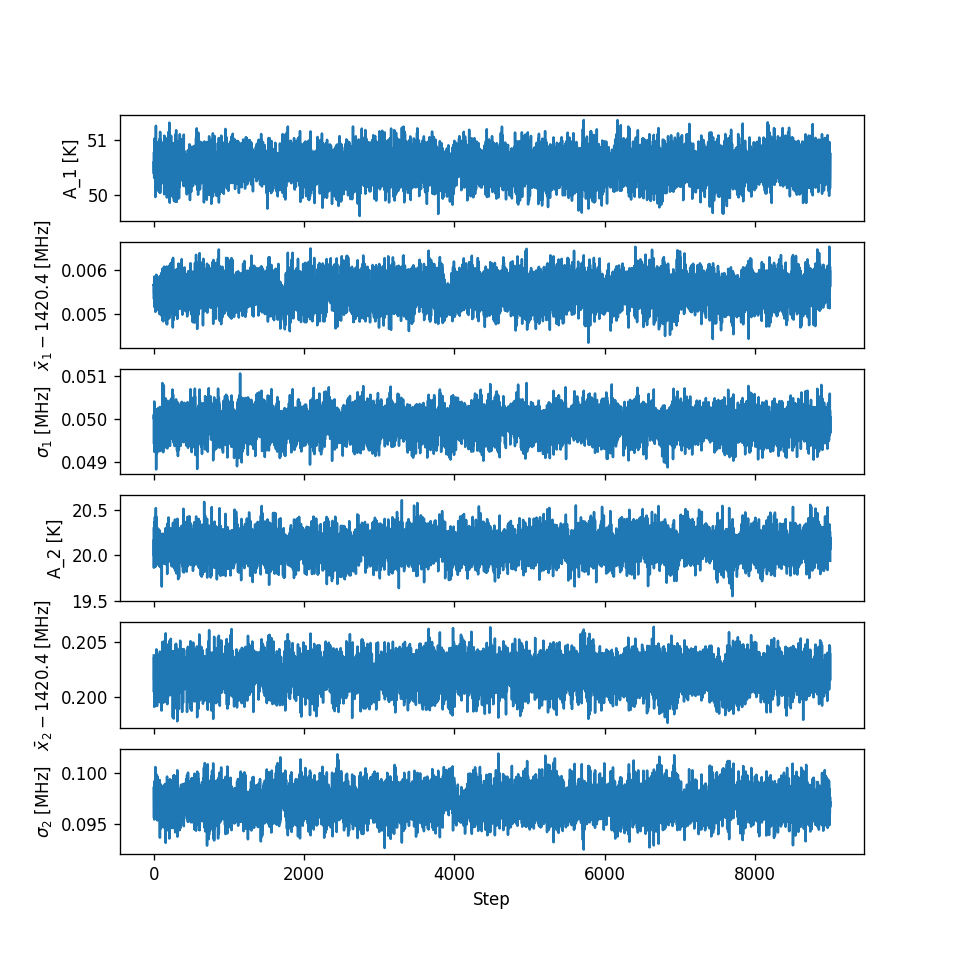

Text(0.5, 0, 'Step')

In [17]:
trace = sampler.get_chain(discard=13750, flat=True, thin=15)
print(trace.shape)
#trace = trace[1500:].reshape(-1, sol0.shape[-1])
#trace = trace.reshape(-1, nprms)
prms = dict(zip(['amp1', 'cen1', 'wid1', 'amp2', 'cen2', 'wid2'], trace.T))

fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(8,8))
axes[0].plot(prms['amp1'])
axes[0].set_ylabel('A_1 [K]')
axes[1].plot(prms['cen1'] / 1e6 - 1420.4)
axes[1].set_ylabel('$\\bar x_1 - 1420.4$ [MHz]')
axes[2].plot(prms['wid1'] / 1e6)
axes[2].set_ylabel('$\\sigma_1$ [MHz]')
axes[3].plot(prms['amp2'])
axes[3].set_ylabel('A_2 [K]')
axes[4].plot(prms['cen2'] / 1e6 - 1420.4)
axes[4].set_ylabel('$\\bar x_2 - 1420.4$ [MHz]')
axes[5].plot(prms['wid2'] / 1e6)
axes[5].set_ylabel('$\\sigma_2$ [MHz]')
axes[5].set_xlabel('Step')

<IPython.core.display.Javascript object>


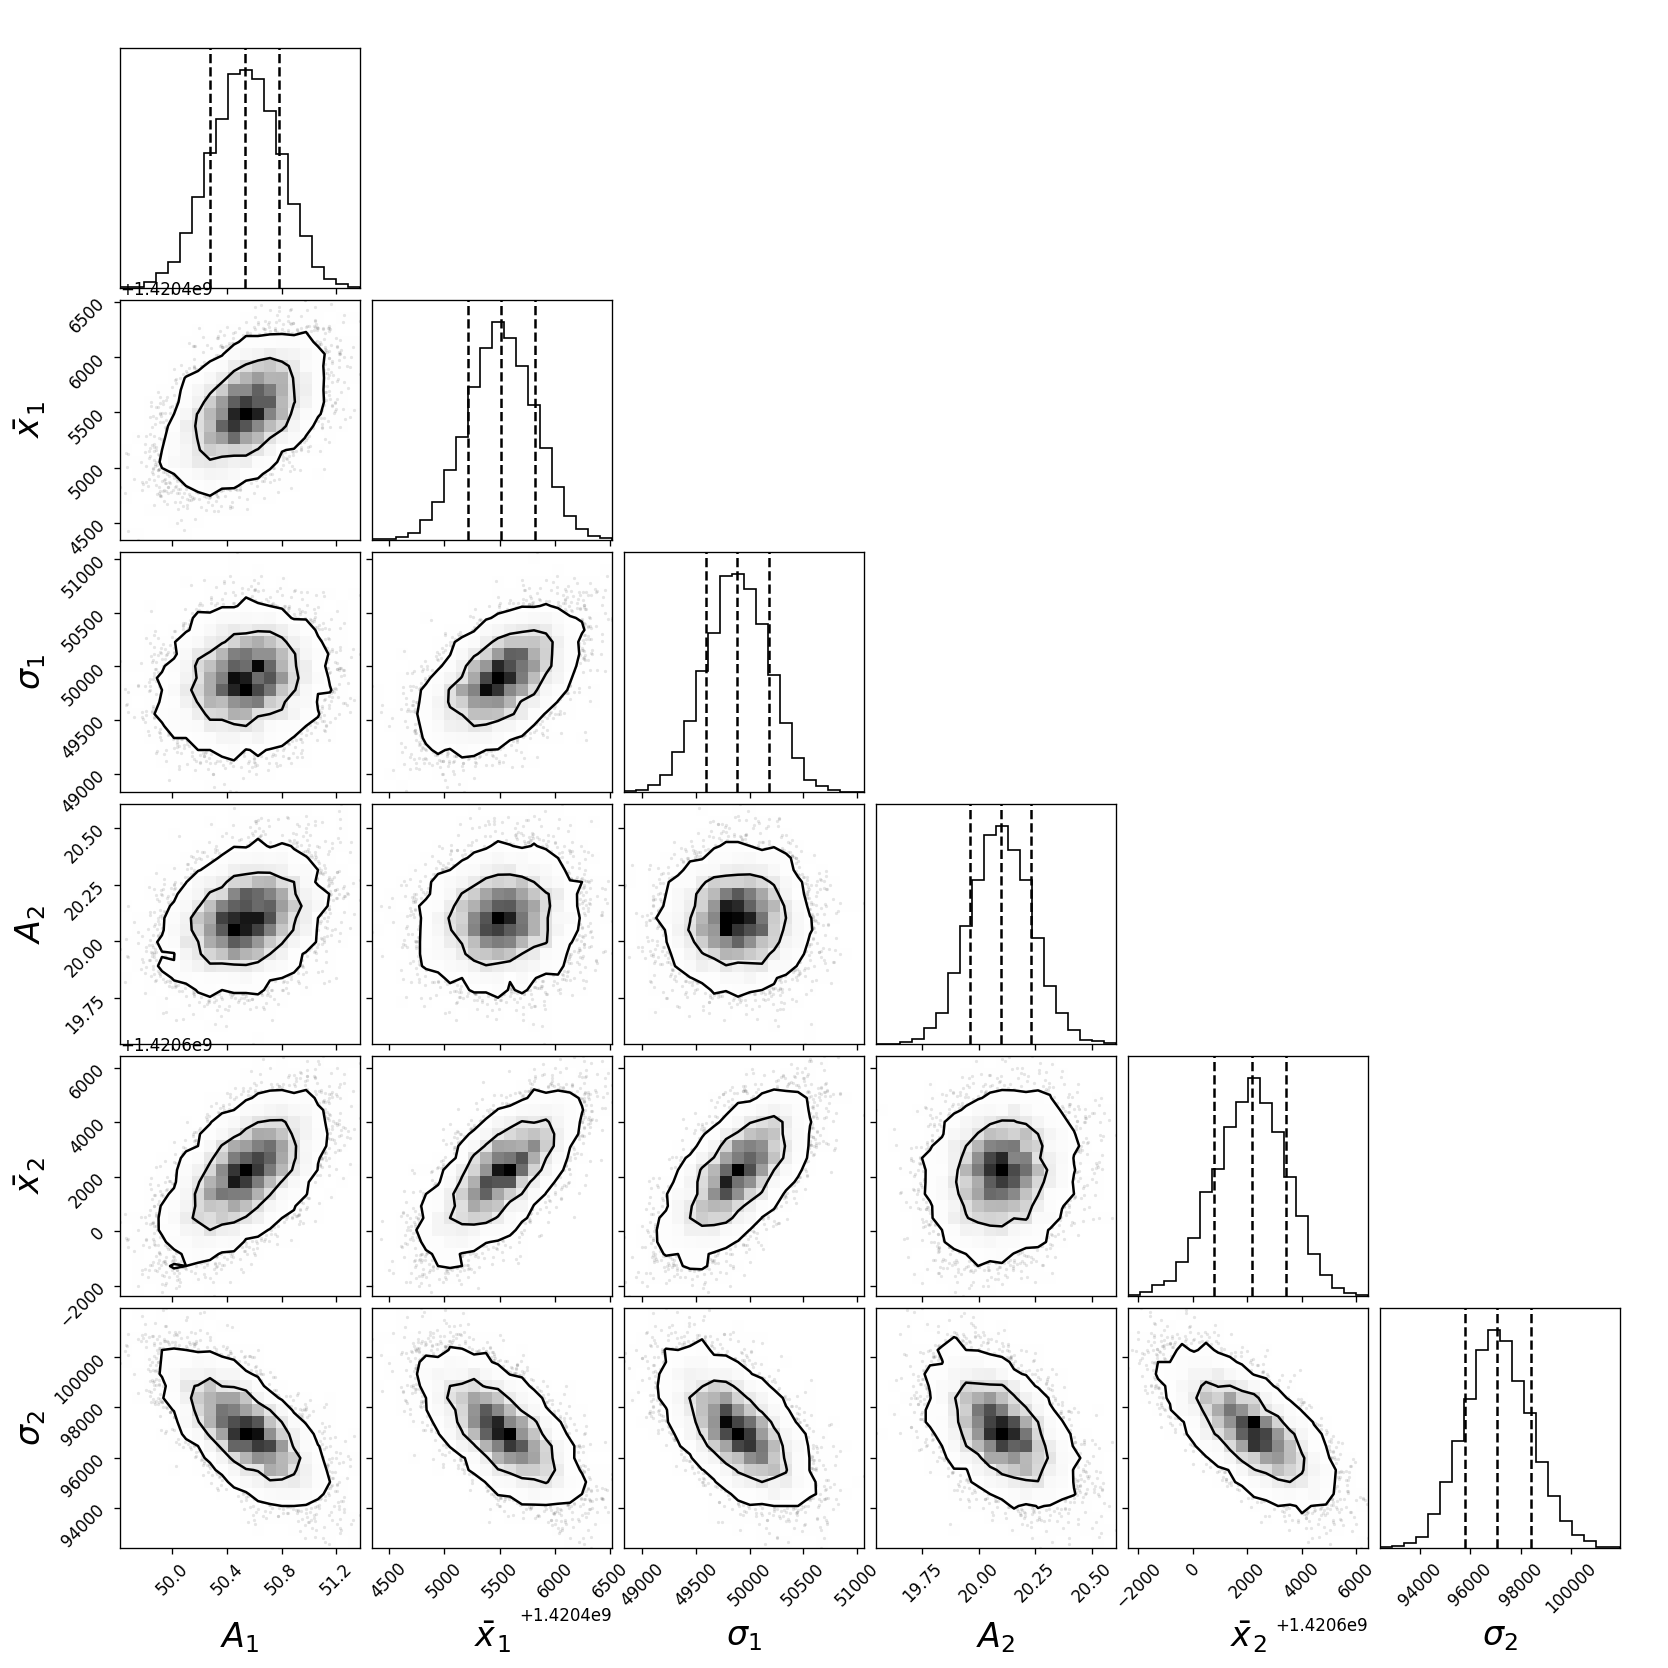

In [18]:
import corner

fig = corner.corner(trace,
        labels = [r'$A_1$', r'$\bar x_1$', r'$\sigma_1$', r'$A_2$', r'$\bar x_2$', r'$\sigma_2$'],
        levels=(0.68, 0.95,),
        label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])

## Markov Chain Monte Carlo (Using PyMC)

In [19]:
#import pymc3 as pm
##import pymc as pm
#import theano
#import theano.tensor as tt

In [20]:
#model = pm.Model()
#
#def gauss(x, amp, center, width):
#    return amp * np.exp(-(x - center)**2 / (2 * width**2))
#
#def log_likelihood(y, yhat, sig_noise):
#    L = -0.5*(np.log(2 * np.pi * sig_noise**2) + (y - yhat)**2 / sig_noise**2 )
#    return tt.sum(L)
#
#with model:
#    amp1 = pm.Uniform('amp1', lower=30, upper=70)
#    cen1 = pm.Uniform('cen1', lower=1420e6, upper=1420.5e6) # separated from 2 below
#    wid1 = pm.Uniform('wid1', lower=0.01e6, upper=0.3e6)
#    amp2 = pm.Uniform('amp2', lower=1, upper=30)
#    cen2 = pm.Uniform('cen2', lower=1420.5e6, upper=1421e6) # separated from 1 above
#    wid2 = pm.Uniform('wid2', lower=0.01e6, upper=0.3e6)
#    yhat = gauss(freqs, amp1, cen1, wid1) + gauss(freqs, amp2, cen2, wid2)
#    sig_noise = theano.shared(TSYS)
#    #yhat = theano.shared(np.asarray(yhat, dtype=theano.config.floatX), borrow=True)
#    
#    pm.Potential("loglike", log_likelihood(y=theano.shared(T21), yhat=yhat, sig_noise=sig_noise))
#
#with model:
#    trace = pm.sample(2500)

In [21]:
#fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(8,8))
#axes[0].plot(trace['amp1'])
#axes[0].set_ylabel('A_1 [K]')
#axes[1].plot(trace['cen1'] / 1e6 - 1420.4)
#axes[1].set_ylabel('$\\bar x_1 - 1420.4$ [MHz]')
#axes[2].plot(trace['wid1'] / 1e6)
#axes[2].set_ylabel('$\\sigma_1$ [MHz]')
#axes[3].plot(trace['amp2'])
#axes[3].set_ylabel('A_2 [K]')
#axes[4].plot(trace['cen2'] / 1e6 - 1420.4)
#axes[4].set_ylabel('$\\bar x_2 - 1420.4$ [MHz]')
#axes[5].plot(trace['wid2'] / 1e6)
#axes[5].set_ylabel('$\\sigma_2$ [MHz]')
#axes[5].set_xlabel('Step')

In [22]:
#import corner
#
#fig = corner.corner(trace, 
#        labels = [r'$A_1$', r'$\bar x_1$', r'$\sigma_1$', r'$A_2$', r'$\bar x_2$', r'$\sigma_2$'],
#        levels=(0.68, 0.95,),
#        label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])

In [23]:
#print(f"amp1 = {np.mean(trace['amp1'])} +/- {np.std(trace['amp1'])}")
#print(f"cen1 = {np.mean(trace['cen1']) / 1e6} +/- {np.std(trace['cen1']) / 1e6}")
#print(f"wid1 = {np.mean(trace['wid1']) / 1e6} +/- {np.std(trace['wid1']) / 1e6}")
#print(f"amp2 = {np.mean(trace['amp2'])} +/- {np.std(trace['amp2'])}")
#print(f"cen2 = {np.mean(trace['cen2']) / 1e6} +/- {np.std(trace['cen2']) / 1e6}")
#print(f"wid2 = {np.mean(trace['wid2']) / 1e6} +/- {np.std(trace['wid2']) / 1e6}")

In [24]:
# Remember the true answers:
# 'amp': np.array([50, 20]),
# 'avg': np.array([1420.405e6, 1420.6e6]),
# 'sig': np.array([0.05e6, 0.1e6])